# SGLBO & SPSA Optimization on Iris Dataset

*This notebook implements and compares SGLBO and SPSA optimizers on the Iris dataset using a Qiskit Quantum Neural Network (QNN).*

##### Cell 1: Environment check

In [1]:
from importlib.metadata import version, PackageNotFoundError
import numpy as np

pkgs = [
    "qiskit",
    "qiskit-aer",
    "qiskit-ibm-runtime",
    "qiskit-machine-learning",
    "qiskit-algorithms"
]

print("Installed Qiskit packages:")
for p in pkgs:
    try:
        print(f"{p:24s}", version(p))
    except PackageNotFoundError:
        print(f"{p:24s}  — not installed —")

Installed Qiskit packages:
qiskit                   1.4.1
qiskit-aer               0.17.0
qiskit-ibm-runtime       0.39.0
qiskit-machine-learning  0.8.2
qiskit-algorithms        0.3.1


##### Cell 2: Constants and Config

In [2]:
seed = 42
batch_size = 16
plateau_eps = 3e-3
plateau_window = 25
budgets = [10_000,50_000, 100_000] #[10_000, 50_000, 100_000]
n_seeds = 10 #20
rng_seed_base   = 42
step = 256

##### Cell 3: Load/preprocess Iris data

In [3]:
from sklearn import datasets, preprocessing, model_selection

X, y = datasets.load_iris(return_X_y=True)
y = (y == 0).astype(int)
X = preprocessing.StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=seed)

##### Cell 4: Circuit and QNN setup

In [4]:
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.primitives import Estimator
from qiskit_machine_learning.neural_networks import EstimatorQNN

num_qubits = X_train.shape[1]
feature_map = ZZFeatureMap(num_qubits, reps=2)
ansatz = RealAmplitudes(num_qubits, reps=2, entanglement="full")
qc = feature_map.compose(ansatz)
estimator = Estimator(options={"shots": 1024})
qnn = EstimatorQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    estimator=estimator
)

/var/folders/qv/j4vz4qdj7qxcfkjfbsnjnn6w0000gn/T/ipykernel_54602/2077152510.py:9: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator(options={"shots": 1024})
/var/folders/qv/j4vz4qdj7qxcfkjfbsnjnn6w0000gn/T/ipykernel_54602/2077152510.py:10: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(


##### Cell 5: Cost function and batch iterator

In [5]:
def batch_iter(X, y, size=batch_size):
    n = len(X)
    while True:
        idx = np.random.choice(n, size, replace=False)
        yield X[idx], y[idx]

train_batches = batch_iter(X_train, y_train, size=batch_size)

def cost_fn(theta, shots, return_var=False, eps=1e-9):
    Xb, yb = next(train_batches)

    # (Re)set shot count for this mini-batch
    if hasattr(estimator, "set_options"):
        estimator.set_options(shots=shots)

    # QNN raw output in [-1, 1]
    raw = qnn.forward(Xb, theta).flatten()

    # --- map to probability ---  p ∈ (0, 1)
    probs = np.clip((raw + 1.0) * 0.5, eps, 1 - eps)

    # Binary-cross-entropy loss
    loss = -np.mean(yb * np.log(probs) + (1 - yb) * np.log(1 - probs))

    if return_var:
        var = np.mean(probs * (1 - probs) / shots)
        return loss, var
    return loss

##### Cell 6: SGLBO class

In [6]:
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition import LogExpectedImprovement as ExpectedImprovement
from botorch.optim import optimize_acqf
from gpytorch.mlls import ExactMarginalLogLikelihood


class SGLBO:
    """
    Stochastic-Gradient-Line Bayesian Optimisation for variational quantum circuits.

    Parameters
    ----------
    theta0 : 1-D numpy array
        Initial parameter vector.
    cost_fn : callable
        Signature ``loss, var = cost_fn(theta, shots, return_var=True)``.
        Must return an unbiased loss estimate and (optionally) its shot-noise variance.
    kappa : float, optional
        Gradient-variance threshold (see Eq. 34 of the paper).  Smaller ⇒ more shots.
    alpha : float, optional
        Fraction of the last iterations to suffix-average (Polyak averaging).
    shots_grad_min / max : int
        Lower / upper bound for adaptive shots used in a single gradient component.
    shots_line : int
        Total shots budget for each 1-D BO line search.
    eta_bound : float
        Search window for the step size η ∈ [−eta_bound, +eta_bound].
    max_shots : int
        Stop automatically when the *cumulative* shots exceed this value.
    max_iter : int
        Hard ceiling on iterations (useful if `max_shots` is ∞).
    dtype : torch dtype
        Precision for the GP model (double by default).
    """

    def __init__(self, theta0, cost_fn,
                 kappa=0.05, alpha=0.3,
                 shots_grad_min=16, shots_grad_max=1024,
                 shots_line=256,
                 eta_bound=0.2,
                 max_shots=np.inf,
                 max_iter=10_000,
                 dtype=torch.double):

        self.theta = np.asarray(theta0, dtype=float)
        self.cost_fn = cost_fn

        # hyper-parameters
        self.kappa = kappa
        self.alpha = alpha
        self.shots_grad_cur = shots_grad_min
        self.shots_grad_min = shots_grad_min
        self.shots_grad_max = shots_grad_max
        self.shots_line = shots_line
        self.eta_bound = eta_bound
        self.max_shots = max_shots
        self.max_iter = max_iter
        self.dtype = dtype

        # bookkeeping
        self.shots_used = 0
        self.T = 0                         # iteration counter
        self.history = []                  # theta, eta, shots_used, ...
        self.avg_theta = np.zeros_like(self.theta)

        # incremental GP data (1-D)
        self.global_X = torch.empty(0, 1, dtype=dtype)
        self.global_Y = torch.empty(0, 1, dtype=dtype)

    # ------------------------------------------------------------------
    # 1. stochastic gradient with adaptive shots
    # ------------------------------------------------------------------
    def _gradient(self):
        grad = np.zeros_like(self.theta)
        for i in range(len(self.theta)):
            shift = np.zeros_like(self.theta)
            shift[i] = np.pi / 2           # parameter-shift rule

            shots = self.shots_grad_cur
            while True:
                f_plus,  var_p = self.cost_fn(self.theta + shift,
                                               shots, return_var=True)
                f_minus, var_m = self.cost_fn(self.theta - shift,
                                               shots, return_var=True)
                var_grad = 0.25 * (var_p + var_m)
                if var_grad <= self.kappa ** 2 or shots >= self.shots_grad_max:
                     break
                shots *= 2                   # double shots and retry

            grad[i] = 0.5 * (f_plus - f_minus)
            self.shots_used += 2 * shots
            
        self.shots_grad_cur = min(2 * self.shots_grad_cur, self.shots_grad_max)
        return grad

    # ------------------------------------------------------------------
    # 2. 1-D Bayesian-optimisation line search (Expected Improvement)
    # ------------------------------------------------------------------
    def _line_bo(self, direction):
        etas_raw = np.array([0.0, 0.1, -0.1]).reshape(-1, 1)
        etas = etas_raw / (2 * self.eta_bound) + 0.5          # map to [0,1]

        ys = np.array([self.cost_fn(self.theta + e_raw * direction,
                            shots=self.shots_line // 3,
                            return_var=False)
               for e_raw in etas_raw])

        X = torch.tensor(etas, dtype=self.dtype)
        Y = torch.tensor(ys, dtype=self.dtype).unsqueeze(-1)

        # append to global history and (re)fit 1-D GP
        self.global_X = torch.cat([self.global_X, X])
        self.global_Y = torch.cat([self.global_Y, Y])

        gp = SingleTaskGP(self.global_X, self.global_Y)
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        fit_gpytorch_mll(mll)

        EI = ExpectedImprovement(gp, best_f=self.global_Y.min())
        bounds = torch.tensor([[0.0], [1.0]], dtype=self.dtype)

        eta_opt_unit, _ = optimize_acqf(EI, bounds=bounds, q=1,
                                num_restarts=5, raw_samples=20)
        eta_opt = (eta_opt_unit.item() - 0.5) * 2 * self.eta_bound
        # spend the remaining shots_line shots on that candidate
        self.shots_used += self.shots_line
        return float(eta_opt)

    # ------------------------------------------------------------------
    # 3. public API:  one optimisation step
    # ------------------------------------------------------------------
    def step(self):
        if self.T >= self.max_iter or self.shots_used >= self.max_shots:
            return False          # signal "stop"

        g = self._gradient()
        if self.shots_used >= self.max_shots:
            return False
        
        d = g / np.linalg.norm(g)
        eta = self._line_bo(d)
        if self.shots_used >= self.max_shots:
            return False

        # parameter update
        self.theta += eta * d

        # suffix (Polyak) averaging
        self.T += 1
        self.history.append((self.theta.copy(), eta, self.shots_used))

        # --- inside step(), suffix averaging ----------------------
        if self.T > (1 - self.alpha) * max(1, self.T):
           w = 1.0 / (self.alpha * self.T)
           self.avg_theta = (1 - w) * self.avg_theta + w * self.theta
        else:
            self.avg_theta = self.theta.copy()   # not yet in suffix window

        return True           # signal "continue"

    # convenience helper ------------------------------------------------
    def run(self):
        """Run until `max_shots` or `max_iter` is reached."""
        while self.step():
            pass
        return self.avg_theta   # best guess of optimum

##### Cell 7: Runner functions for SGLBO and SPSA

In [7]:
def run_sglbo(seed, budget_shots=50_000, verbose=False,cost_fn=None):
    if cost_fn is None:                   # fall back to the global one
        cost_fn = globals()["cost_fn"]
    rng = np.random.default_rng(seed)
    theta0 = rng.standard_normal(ansatz.num_parameters)

    opt = SGLBO(theta0, cost_fn,
                max_shots=budget_shots, max_iter=2000,
                shots_line=128, shots_grad_min=32, shots_grad_max=256,
                alpha=0.3, kappa=0.05)

    shots_hist, loss_hist, acc_hist = [], [], []
    stop_reason = "unknown"                       # initialise

    while True:
        cont = opt.step()                         # one optimiser step
        if not cont:                              # budget or max-iter fuse
            stop_reason = "budget / max_iter"
            break

        # ── diagnostics ──
        shots_hist.append(opt.shots_used)

        if hasattr(estimator, "set_options"):
            estimator.set_options(shots=256)
        loss_val = cost_fn(opt.theta, 256, False)
        loss_hist.append(loss_val)

        probs = (qnn.forward(X_test, opt.theta).flatten() + 1) * 0.5
        acc_val = ((probs > 0.5).astype(int) == y_test).mean()
        acc_hist.append(acc_val)
        # ───────────────────────────────────────────────────────────────

        if verbose and opt.T % 2 == 0:                        # console trace
            print(f"Iter {opt.T:2d} | shots {opt.shots_used:7d} "
                  f"| grad_shots {opt.shots_grad_cur:4d} "
                  f"| loss {loss_val:6.3f} | acc {acc_val:5.3f}")

        # plateau check (relative 1 % over last 10 logs)
        flat = (len(loss_hist) > plateau_window and
                abs(loss_hist[-1] - loss_hist[-1 - plateau_window]) <
                plateau_eps * abs(loss_hist[-1 - plateau_window]))

        if flat:
            stop_reason = "plateau"
            break                                  # early-stop fuse

    if verbose:
        print("Run stopped due to:", stop_reason,
              "| final shots:", shots_hist[-1],
              "| best loss:", np.min(loss_hist),
              "| best acc:",  np.max(acc_hist))
    
    return (np.array(shots_hist),
            np.array(loss_hist),
            np.array(acc_hist),
            opt.avg_theta)

# SPSA
from qiskit_algorithms.optimizers import SPSA
def run_spsa(seed, budget_shots=50_000, *, verbose=False,cost_fn=None):
    if cost_fn is None:                   # fall back to the global one
        cost_fn = globals()["cost_fn"]
    rng         = np.random.default_rng(seed)
    theta0      = rng.standard_normal(ansatz.num_parameters)

    shots_per_eval  = 256
    spsa_shots_used = 0
    shots_hist, loss_hist, acc_hist = [], [], []
    theta_last = theta0.copy()
    stop_reason = "unknown"

    # ───────── objective wrapper ─────────
    def spsa_objective(theta):
        nonlocal spsa_shots_used, theta_last, stop_reason
        theta_last = theta

        if hasattr(estimator, "set_options"):
            estimator.set_options(shots=shots_per_eval)
        loss = cost_fn(theta, shots_per_eval, False)


        # ------- shot accounting --------
        spsa_shots_used += shots_per_eval
        if spsa_shots_used >= budget_shots:
            stop_reason = "budget"
            raise StopIteration
        # ---------------------------------

        # log once per optimiser iteration
        if len(shots_hist) == 0 or spsa_shots_used > shots_hist[-1]:
            shots_hist.append(spsa_shots_used)

            if hasattr(estimator, "set_options"):
                estimator.set_options(shots=256)
            loss_val = cost_fn(theta, 256, False)
            loss_hist.append(loss_val)

            probs = (qnn.forward(X_test, theta).flatten() + 1) * 0.5
            acc_val = ((probs > 0.5).astype(int) == y_test).mean()
            acc_hist.append(acc_val)

            # console trace
            if verbose:
                print(f"SPSA iter {len(shots_hist):3d} | "
                      f"shots {spsa_shots_used:7d} | "
                      f"loss {loss_val:6.3f} | acc {acc_val:5.3f}")

            # plateau check (relative 1 %)
            flat = (len(loss_hist) > plateau_window and
                    abs(loss_hist[-1] - loss_hist[-1 - plateau_window]) <
                    plateau_eps * abs(loss_hist[-1 - plateau_window]))
            if flat:
                stop_reason = "plateau"
                raise StopIteration

        return loss
    # ────────────────────────────────────

    spsa = SPSA(maxiter=300, learning_rate=0.05, perturbation=0.1)

    try:
        res = spsa.minimize(fun=spsa_objective, x0=theta0)
        theta_final  = res.x
        stop_reason  = "maxiter"
    except StopIteration:
        theta_final = theta_last

    # one-line summary
    if verbose:
        print(f"SPSA stopped due to: {stop_reason} | "
              f"final shots: {shots_hist[-1]}")

    return (np.array(shots_hist),
            np.array(loss_hist),
            np.array(acc_hist),
            theta_final,
            stop_reason)

##### Cell 8: Run all experiments and collect results

In [8]:
results = {opt: {b: [] for b in budgets} for opt in ["sglbo", "spsa"]}

for b in budgets:
    for s in range(n_seeds):
        seed = rng_seed_base + s

        # --- SGLBO ----------------------------------------------------
        res_sglbo = run_sglbo(seed, b)
        if len(res_sglbo[0]) > 0:                
            results["sglbo"][b].append(res_sglbo)
        else:
            print(f"[sglbo] seed {s} budget {b} produced no data – skipped")

        # --- SPSA -----------------------------------------------------
        res_spsa = run_spsa(seed, b)
        if len(res_spsa[0]) > 0:
            results["spsa"][b].append(res_spsa)
        else:
            print(f"[spsa] seed {s} budget {b} produced no data – skipped")

##### Cell 9: Plotting utilities and results

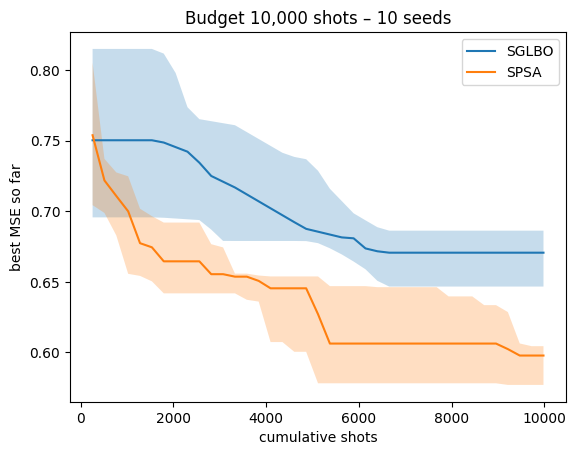

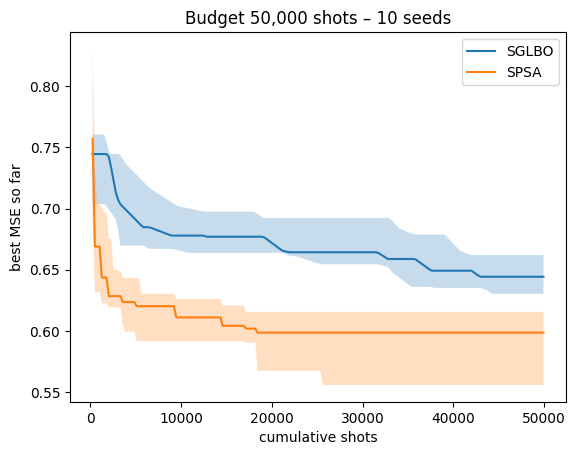

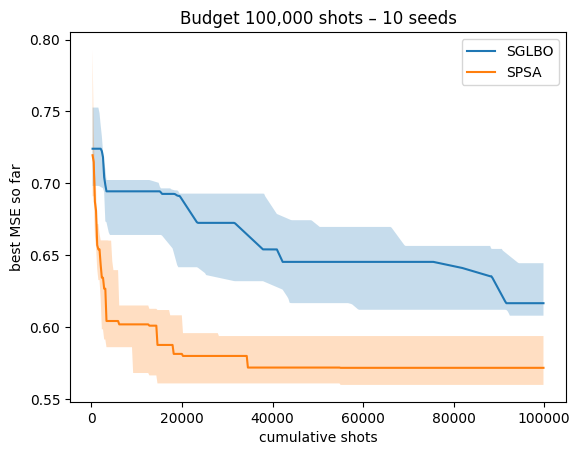

In [9]:
import matplotlib.pyplot as plt

def best_so_far(arr):
    return np.minimum.accumulate(arr)

for b in budgets:
    plt.figure()
    grid = np.arange(step, b + 1, step)  # <<<<<< match shot increments!
    for name in ["sglbo", "spsa"]:
        curves = []
        for sh, lh, *_ in results[name][b]:
            if len(sh) == 0 or len(lh) == 0:
                continue
            running_best = best_so_far(lh)
            curves.append(
                np.interp(
                    grid,
                    sh,
                    running_best,
                    left=running_best[0],
                    right=running_best[-1]
                )
            )
        if len(curves) == 0:
            print(f"[{name}] No data for budget {b}")
            continue
        curves = np.vstack(curves)
        median = np.nanmedian(curves, axis=0)
        q1, q3 = np.nanpercentile(curves, [25, 75], axis=0)
        plt.plot(grid, median, label=name.upper())
        plt.fill_between(grid, q1, q3, alpha=0.25)
    plt.title(f"Budget {b:,} shots – {n_seeds} seeds")
    plt.xlabel("cumulative shots")
    plt.ylabel("best MSE so far")
    plt.legend()
    plt.show()
    plt.close()

##### Cell 10: Build noise models and create Aer/Backend estimators

In [10]:
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError
from qiskit.primitives import BackendEstimator, StatevectorEstimator

def make_noise_model(p_1q=0.001, p_2q=0.01, p_ro=0.02):
    noise = NoiseModel()
    noise.add_all_qubit_quantum_error(depolarizing_error(p_1q, 1), ['u3'])
    noise.add_all_qubit_quantum_error(depolarizing_error(p_2q, 2), ['cx'])
    ro = ReadoutError([[1-p_ro, p_ro], [p_ro, 1-p_ro]])
    for q in range(num_qubits):
        noise.add_readout_error(ro, [q])
    return noise

levels = {
    "noiseless": None,
    "low":    make_noise_model(0.0005, 0.005, 0.01),
    "medium": make_noise_model(0.001,  0.01,  0.02),
    "high":   make_noise_model(0.003,  0.03,  0.05)
}

estimators = {}
for tag, nm in levels.items():
    if nm is None:
        estimators[tag] = StatevectorEstimator()
    else:
        simul = AerSimulator(noise_model=nm)
        simul.set_options(shots=1024)
        estimators[tag] = BackendEstimator(backend=simul)

/var/folders/qv/j4vz4qdj7qxcfkjfbsnjnn6w0000gn/T/ipykernel_54602/2806695010.py:28: DeprecationWarning: The class ``qiskit.primitives.backend_estimator.BackendEstimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendEstimator` class is `BackendEstimatorV2`.
  estimators[tag] = BackendEstimator(backend=simul)


##### Cell 11: Run SGLBO & SPSA across noise levels and log results

In [11]:
noise_results = {tag: {opt: {b: [] for b in budgets}
                       for opt in ["sglbo", "spsa"]}
                 for tag in estimators}

for tag, est in estimators.items():
    print(f"\n=== Running {tag} noise ===")
    estimator = est  # update global variable, so cost_fn uses the right one

    for seed in range(n_seeds):
        rng = np.random.default_rng(seed)
        theta0 = rng.standard_normal(ansatz.num_parameters)

        # new QNN, new batch generator for *this* seed
        qnn = EstimatorQNN(
            circuit=qc,
            input_params=feature_map.parameters,
            weight_params=ansatz.parameters,
            estimator=estimator
        )
        train_batches = batch_iter(X_train, y_train, size=batch_size)

        # use global cost_fn, no need to redefine
        for b in budgets:
            noise_results[tag]["sglbo"][b].append(
                run_sglbo(seed, b, cost_fn=cost_fn)
            )
            noise_results[tag]["spsa"][b].append(
                run_spsa(seed, b, cost_fn=cost_fn)
            )
    print(f"{tag} noise: all seeds done ✔︎")

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.



=== Running noiseless noise ===


No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.
No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.
No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.
No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.
No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.
No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.
No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.
No gradient function provided, creating a gradient function. I

noiseless noise: all seeds done ✔︎

=== Running low noise ===


/var/folders/qv/j4vz4qdj7qxcfkjfbsnjnn6w0000gn/T/ipykernel_54602/2385177821.py:14: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(
/opt/anaconda3/envs/sglbo-env/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/var/folders/qv/j4vz4qdj7qxcfkjfbsnjnn6w0000gn/T/ipykernel_54602/2385177821.py:14: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(
/var/folders/qv/j4vz4qdj7qxcfkjfbsnjnn6w0000gn/T/ipykernel_54602/2385177821.py:14: DeprecationWarning: V1 Primitives are deprecated as of qiskit-mac

low noise: all seeds done ✔︎

=== Running medium noise ===


/var/folders/qv/j4vz4qdj7qxcfkjfbsnjnn6w0000gn/T/ipykernel_54602/2385177821.py:14: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(
/var/folders/qv/j4vz4qdj7qxcfkjfbsnjnn6w0000gn/T/ipykernel_54602/2385177821.py:14: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(
/var/folders/qv/j4vz4qdj7qxcfkjfbsnjnn6w0000gn/T/ipykernel_54602/2385177821.py:14: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(
/var/folders/qv/j4vz4qdj7qxcfkjfbsnjnn6w0000gn/T/

medium noise: all seeds done ✔︎

=== Running high noise ===


/var/folders/qv/j4vz4qdj7qxcfkjfbsnjnn6w0000gn/T/ipykernel_54602/2385177821.py:14: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(
/var/folders/qv/j4vz4qdj7qxcfkjfbsnjnn6w0000gn/T/ipykernel_54602/2385177821.py:14: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(
/var/folders/qv/j4vz4qdj7qxcfkjfbsnjnn6w0000gn/T/ipykernel_54602/2385177821.py:14: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(
/var/folders/qv/j4vz4qdj7qxcfkjfbsnjnn6w0000gn/T/

high noise: all seeds done ✔︎


##### Cell 12: Plot best-so-far loss vs. shots for each noise level

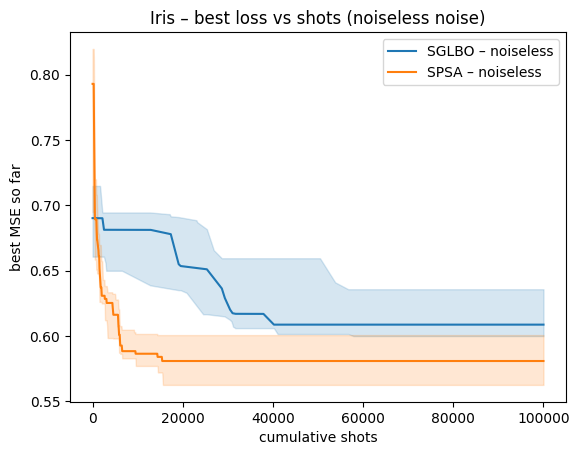

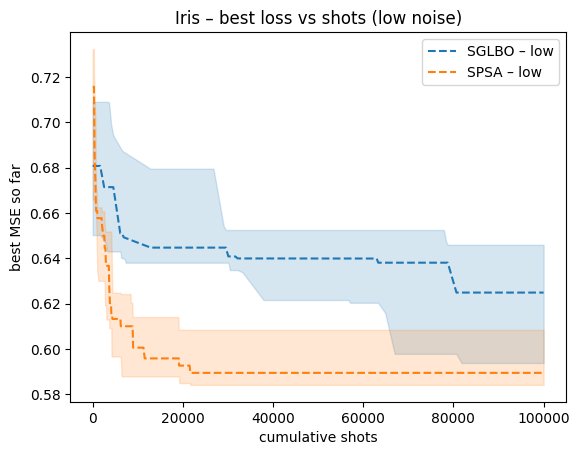

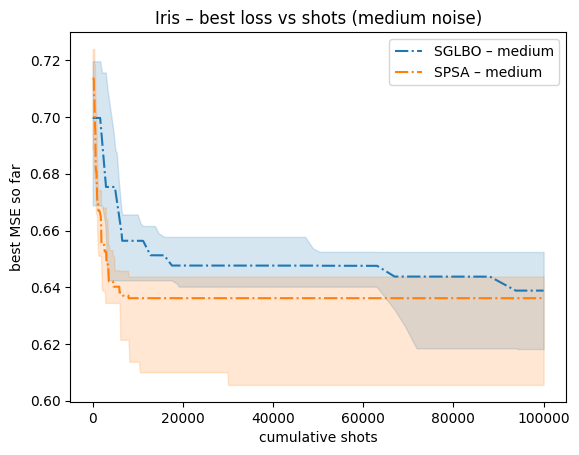

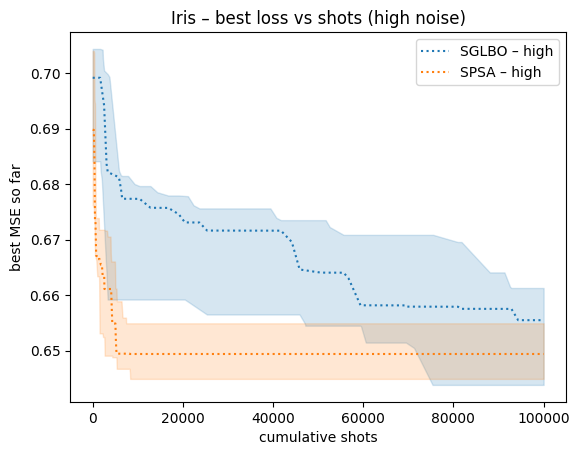

In [12]:
import matplotlib.pyplot as plt

colors = {"sglbo": "tab:blue", "spsa": "tab:orange"}
linestyles = {"noiseless":"-", "low":"--", "medium":"-.", "high":":"}

for tag in levels:
    plt.figure()
    for name in ["sglbo", "spsa"]:
        grid = np.arange(8, budgets[-1]+1, 8)
        curves = []
        for sh, lh, *_ in noise_results[tag][name][budgets[-1]]:
            # Only add if sh and lh are both non-empty
            if len(sh) == 0 or len(lh) == 0:
                continue
            running_best = np.minimum.accumulate(lh)
            curves.append(
                np.interp(grid, sh, running_best, left=running_best[0], right=running_best[-1])
            )
        if len(curves) == 0:
            print(f"[{tag} {name}] No data for budget {budgets[-1]}")  # <— for debug
            continue
        curves = np.vstack(curves)
        median = np.nanmedian(curves, axis=0)
        q1, q3 = np.nanpercentile(curves, [25, 75], axis=0)
        plt.plot(grid, median, label=f"{name.upper()} – {tag}",
                 color=colors[name], linestyle=linestyles[tag])
        plt.fill_between(grid, q1, q3, alpha=0.18, color=colors[name])
    plt.title(f"Iris – best loss vs shots ({tag} noise)")
    plt.xlabel("cumulative shots")
    plt.ylabel("best MSE so far")
    plt.legend()
    plt.show()
    plt.close()

##### Cell 13: Connect to IBM Quantum and do a 10 k-shot smoke-test on hardware (or fallback simulator)

In [ ]:
# Connect to IBM Quantum and run a quick 10 k-shot smoke-test
# for both optimisers on the least-busy real backend (or a
# simulator fallback if all real devices are unavailable).
#
# Prereqs:
#   • Stored an IBM Quantum API token 
#   • `num_qubits` is already defined (4 for Iris)
#   • run_sglbo / run_spsa are in scope from earlier cells
#   • cost_fn/qnn refer to the *global* `estimator` object

from qiskit_ibm_runtime import QiskitRuntimeService, Estimator as RtEstimator
from qiskit_ibm_runtime import Session

# 1️⃣  Authenticate and choose a backend
svc = QiskitRuntimeService(channel="ibm_quantum")
try:
    backend = svc.least_busy(simulator=False, min_num_qubits=num_qubits)
except Exception as exc:
    print("No real backends available → falling back to a simulator.")
    backend = svc.least_busy(simulator=True, min_num_qubits=num_qubits)

print("Running on backend:", backend.name)

# 2️⃣  Open a persistent runtime session so multiple jobs share the queue slot
session = Session(service=svc, backend=backend)

# 3️⃣  Create a Runtime Estimator and expose it globally
estimator = RtEstimator(session=session, options={"shots": 1024})
globals()["estimator"] = estimator      # make cost_fn/qnn see this one

# 4️⃣  Smoke-test each optimiser with a 10 k-shot budget
for helper in [run_sglbo, run_spsa]:
    result = helper(seed=0, budget_shots=10_000)
    shots_hist = result[0]
    stop_reason = result[4] if len(result) == 5 else "finished"
    print(f"{helper.__name__} stopped due to {stop_reason} – "
          f"shots used: {shots_hist[-1]}")

# 5️⃣  Clean up
session.close()